In [69]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torchvision import transforms

from dataset import CaptionsDataset
from utils import train_loop, eval_model, analyze_errors
from models import OCRModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
IMAGE_FOLDER = './samples'
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
IS_CUDA = DEVICE != 'cpu'
BATCH_SIZE = 64
N_EPOCHS = 50

### Data Preparation

In [3]:
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

transformer = transforms.Compose([
    transforms.Normalize(image_mean, image_std)
])

dataset = CaptionsDataset(image_folder=IMAGE_FOLDER, transform=transformer)

In [4]:
test_ratio = 0.25
test_size = int(test_ratio * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - test_size, test_size]) 

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=IS_CUDA)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=IS_CUDA)

In [5]:
dataset.num_tokens

20

### Model Definition and Training

In [6]:
model = OCRModel(dataset.num_tokens).to(device=DEVICE)
opt = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, cooldown=2, min_lr=1e-7)
loss_func = nn.CTCLoss(zero_infinity=True)

In [7]:
print(model)

OCRModel(
  (_conv): Sequential(
    (0): ConvBlock(
      (_block): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
          (1): ReLU()
        )
        (2): Sequential(
          (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
          (1): ReLU()
        )
        (3): Sequential(
          (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
          (1): ReLU()
        )
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (_block): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padd

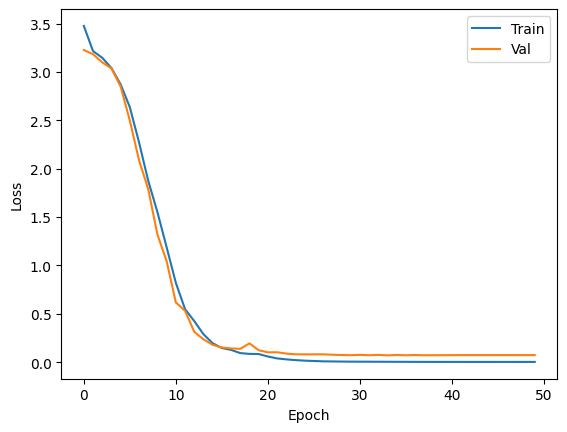

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]

Final Loss: 0.0028291471445789705


In [8]:
train_loop(
    model=model, loss_func=loss_func, opt=opt,
    scheduler=scheduler,
    n_epoch=N_EPOCHS,
    train_loader=train_loader,
    val_loader=test_loader,
    device=DEVICE,
)

### Model Evaluation

1. CER on train data:

In [9]:
eval_model(model, train_loader, DEVICE)

0.0

2. CER on test data

In [10]:
eval_model(model, test_loader, DEVICE)

0.011390472

In [11]:
path_to_save = 'model_final.pkl'
torch.save(
    {
        'model': model.state_dict(),
        'optimizer': opt.state_dict(),
        'scheduler': scheduler.state_dict(),
    },
    path_to_save
)

### Model Error Analysis

Even though model shows good CER results on test data (~1.13%), let's take a look at some error cases.

In [70]:
batch_errors = analyze_errors(model, test_loader, DEVICE)

In [71]:
for imgs, captions, captions_pred in batch_errors:
    print(f'Captions          : {captions}')
    print(f'Predicted Captions: {captions_pred}')

Captions          : ['mggce', 'd22bd', '8cccc', 'xcf88', 'gxxpf']
Predicted Captions: ['mgce', 'd2bd', '8ccc', 'xcf8', 'gxpf']
Captions          : ['wb3ed', 'g55b4', '6n6gg']
Predicted Captions: ['wbed', 'g5b4', '6n6g']
Captions          : ['xnn4d', '5n732', '3xng6', 'b55d6', 'x277e', 'cnmnn', 'pnnwy']
Predicted Captions: ['xn4d', '5n7322', '5xng6', 'b5d6', 'x27e', 'cnmn', 'pnwy']
Captions          : ['d22y5', 'n7ff2', 'wddcp']
Predicted Captions: ['d2y5', 'n7f2', 'wdcp']
Captions          : []
Predicted Captions: []
